# Professions: comparison (wikipedia)

In the following notebook we're going to compare all the approaches we developed and test them on a small amount of professions for which we have precise statics about. We will use both FastText's and Gonen's embeddings.

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load FastText's emdeddings (wikipedia only)
E_ft =  WordEmbedding('../embedding/fast-text/wiki.it.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/wiki.it.reduced.vec
(465, 300)
465 words of dimension 300 : sua, suo, prima, italiano, ..., credulona, calzolaia, supportivo, agrotecnica
465 words of dimension 300 : sua, suo, prima, italiano, ..., credulona, calzolaia, supportivo, agrotecnica


### Step 2: working whit FastText's embeddings

#### Step 2.1: vector difference

In [3]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

#### Step 2.2: PCA

In [4]:
# list of pairs to define gender
'''
gender_pairs = [['lei','lui'],
                ['donna','uomo'], 
                ['madre','padre'],
                ['moglie','marito'],
                ['sorella','fratello'],
                ['femmina','maschio']]
'''

gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [5]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [6]:
print("Singular values:")
print(sv)

Singular values:
[7.9063672e-01 4.8787877e-01 3.9824027e-01 3.5311949e-01 3.3102319e-01
 2.5868079e-01 7.1079853e-08 5.8829958e-08 5.3196310e-08 4.3196874e-08]


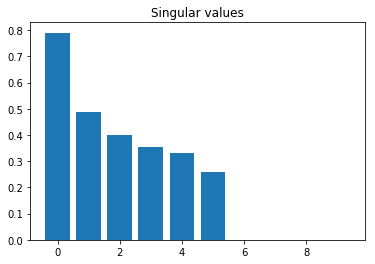

In [7]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [8]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

#### Step 2.3: pseudo-LDA

In [9]:
'''
S_word = [['lei','lui'],
          ['donna','uomo'],
          ['madre','padre'],
          ['moglie','marito'],
          ['sorella','fratello'],
          ['femmina','maschio']]
'''

S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [10]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [11]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [12]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

#### Step 2.4: compute projections

##### Ungendered professions

In [13]:
# read professions
prof_ung_truth = db.read('professions_ung.csv', 'truth')

In [14]:
# compute projection of each profession on g_diff
proj_ung_g_diff = db.prof_proj(E_ft, prof_ung_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_ung_g_pca_0 = db.prof_proj(E_ft, prof_ung_truth, g_pca_0, 'istat')

# compute projection of each profession on g_pca_01
proj_ung_g_pca_01 = db.prof_proj(E_ft, prof_ung_truth, g_pca_01, 'istat')

# compute projection of each profession on g_e
proj_ung_g_e = db.prof_proj(E_ft, prof_ung_truth, g_e, 'istat')

In [15]:
# print results
ung_col0 = [] # pandas columns
ung_col1 = []
ung_col2 = []
ung_col3 = []
ung_col4 = []
ung_col5 = []
ung_col6 = []

for i in range(len(proj_ung_g_diff)):
    ung_col0.append(proj_ung_g_diff[i][0]) # profession
    ung_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    ung_col2.append(-proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    ung_col3.append(-proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    ung_col4.append(-np.real(proj_ung_g_e[i][1])) # projection on g_e
    ung_col5.append(proj_ung_g_diff[i][2]) # %male
    ung_col6.append(proj_ung_g_diff[i][3]) # %female

    
ung_data = {'Profession':ung_col0, 
           'Proj g_diff':ung_col1,
           'Proj g_pca_0':ung_col2, 
           'Proj g_pca_01':ung_col3,
           'Prog g_e':ung_col4,
           '% male':ung_col5, 
           '% female':ung_col6}
ung_table = pd.DataFrame(ung_data)
ung_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% male,% female
0,camionista,-0.042458,0.016446,-0.040143,0.007540,96.9,3.1
1,elettricista,0.013177,0.051736,-0.005166,0.038902,96.8,3.2
2,ingegnere,0.085678,0.117457,0.075780,0.024595,83.6,16.4
3,architetto,0.064599,0.092906,0.091133,0.020600,64.7,35.3
4,notaio,0.079254,0.082158,-0.012314,0.008138,66.4,33.6
5,commercialista,0.004727,0.014477,-0.003712,0.010050,68.2,31.8
6,giornalista,-0.039752,-0.040363,-0.074976,0.052038,54.7,45.3
7,insegnante,-0.113096,-0.060914,-0.091841,-0.061973,17.3,82.7
8,barista,-0.023749,0.003859,-0.065955,-0.010324,38.9,61.1
9,medico,-0.005949,0.021420,-0.011979,0.016444,56.3,43.7


In [16]:
#ung_table.to_csv('truth_ung_ft.csv', index=False)

In [17]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[0]
r_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[0]
r_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[0]

p_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[1]
p_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[1]
p_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[1]

In [18]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0],
                'g_pca_01':[r_g_pca_01,p_g_pca_01],
                'g_e':[r_g_e,p_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.568677,-0.608877,-0.52164,-0.435741
p,0.021523,0.012306,0.03823,0.091581


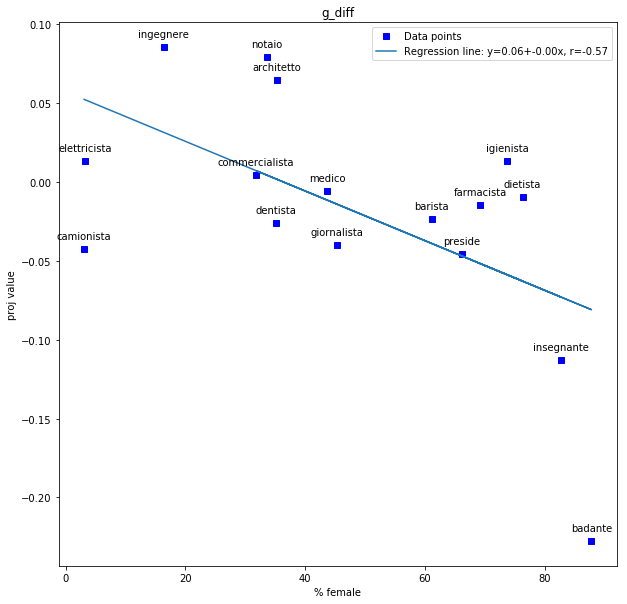

In [19]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_diff')

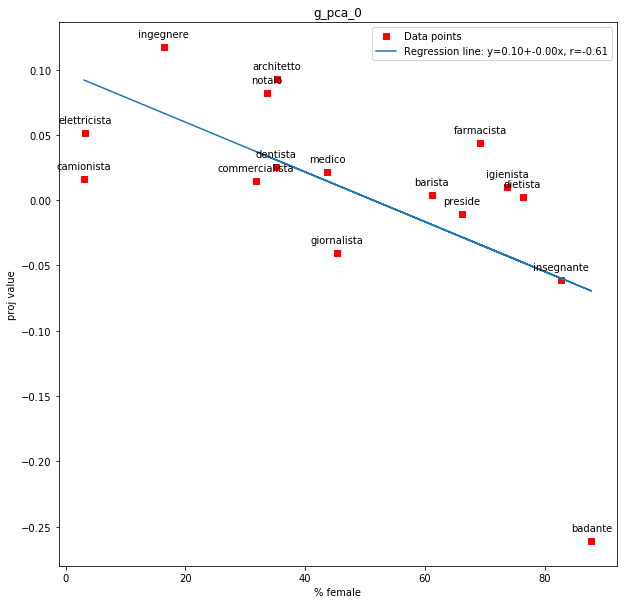

In [20]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_pca_0')

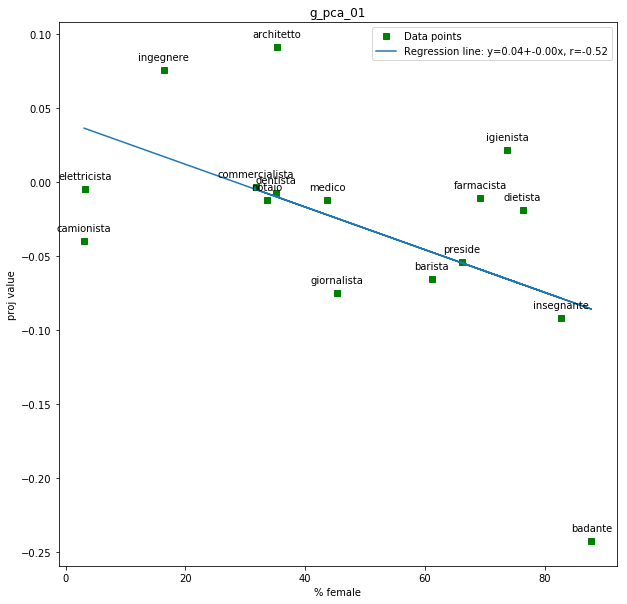

In [21]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")

ax.legend(facecolor='white')
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_pca_01')

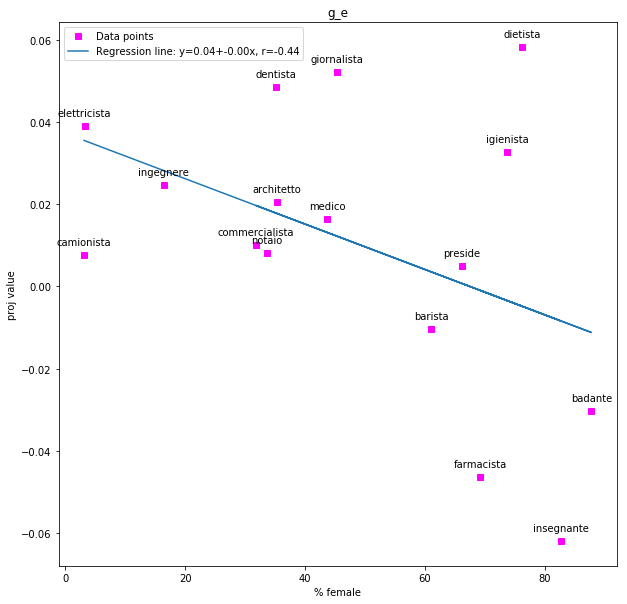

In [22]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_e')

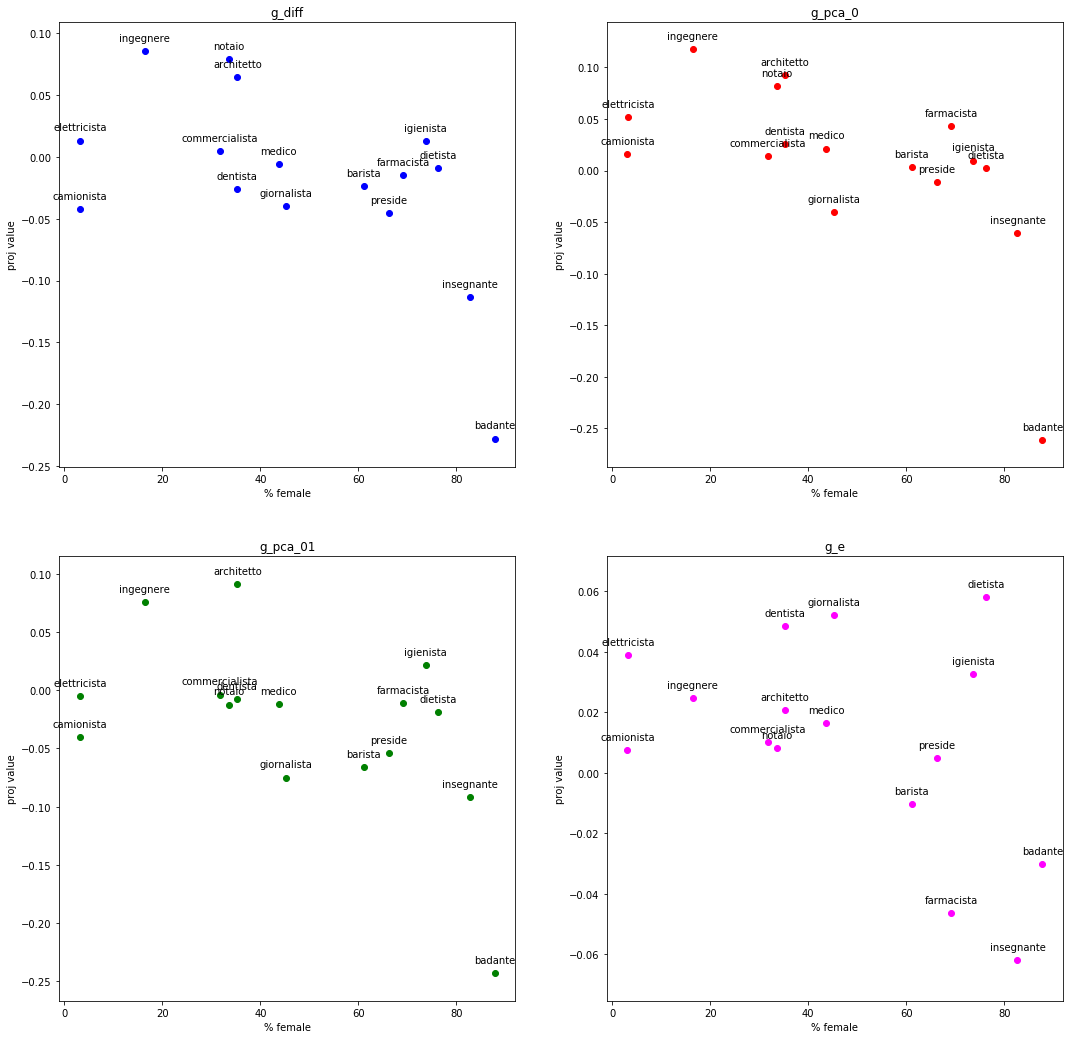

In [23]:
# scatter plots

plt.figure(figsize=(18,18))    

ax1 = plt.subplot(221)
ax1.scatter(ung_col6, ung_col1, c='blue')
ax1.set_title('g_diff')
ax1.set_xlabel('% female')
ax1.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax2 = plt.subplot(222)
ax2.scatter(ung_col6, ung_col2, c='red')
ax2.set_title('g_pca_0')
ax2.set_xlabel('% female')
ax2.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax3 = plt.subplot(223)
ax3.scatter(ung_col6, ung_col3, c='green')
ax3.set_title('g_pca_01')
ax3.set_xlabel('% female')
ax3.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax4 = plt.subplot(224)
ax4.scatter(ung_col6, ung_col4, c='magenta')
ax4.set_title('g_e')
ax4.set_xlabel('% female')
ax4.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()
#fig.savefig('plot/ung/scatter/ft_all')

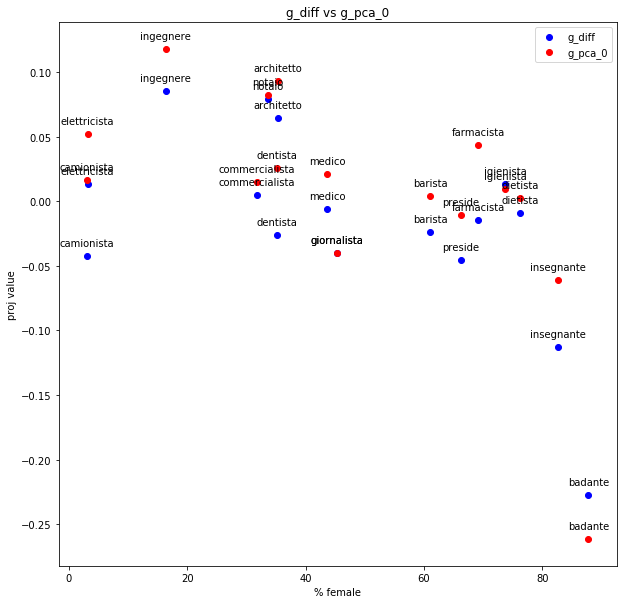

In [24]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.set_title('g_diff vs g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_g_diff_vs_g_pca_0')

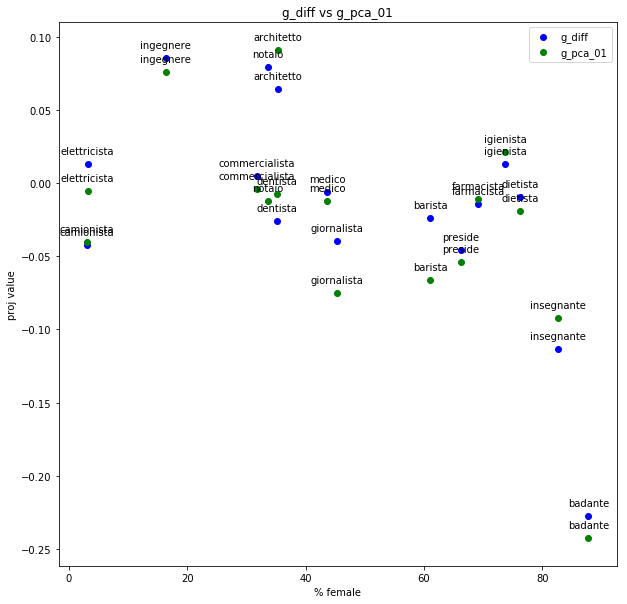

In [25]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_diff vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_g_diff_vs_g_pca_01')

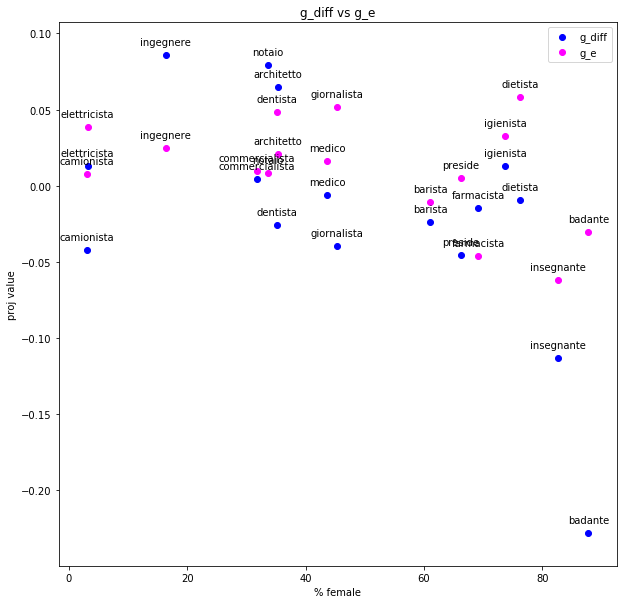

In [26]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_diff vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_g_diff_vs_g_e')

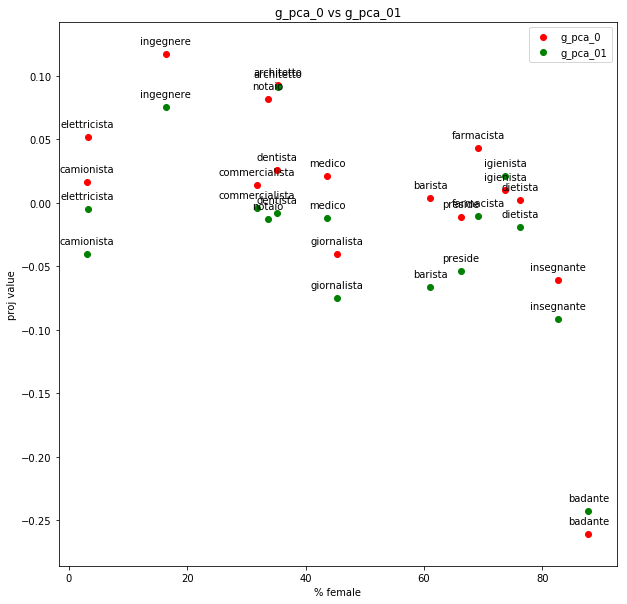

In [27]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_pca_0 vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_g_pca_0_vs_g_pca_01')

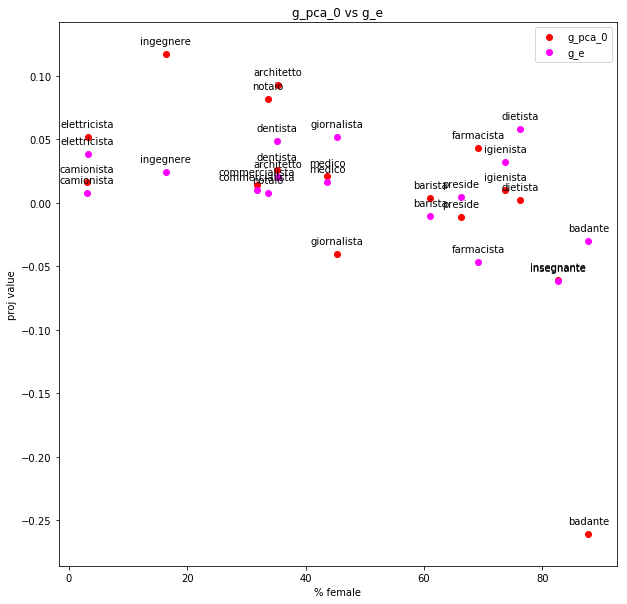

In [28]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_0 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_g_pca_0_vs_g_e')

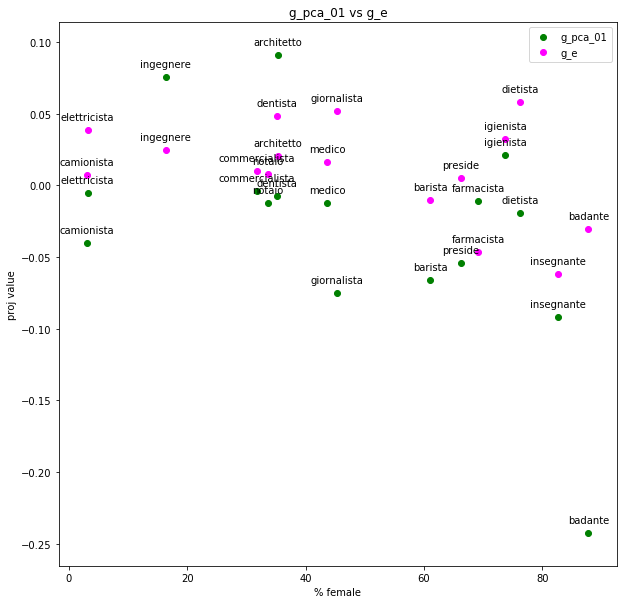

In [29]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_01 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_g_pca_01_vs_g_e')

##### Gendered professions

In [30]:
# read professions
prof_gen_truth = db.read('professions_gen.csv', 'truth-mf')

In [31]:
# compute projection of each profession on g_diff
proj_gen_g_diff = db.prof_proj(E_ft, prof_gen_truth, g_diff, 'istat-mf')

# compute projection of each profession on g_pca_0
proj_gen_g_pca_0 = db.prof_proj(E_ft, prof_gen_truth, g_pca_0, 'istat-mf')

# compute projection of each profession on g_pca_01
proj_gen_g_pca_01 = db.prof_proj(E_ft, prof_gen_truth, g_pca_01, 'istat-mf')

# compute projection of each profession on g_e
proj_gen_g_e = db.prof_proj(E_ft, prof_gen_truth, g_e, 'istat-mf')

In [32]:
# print results
gen_col0 = [] # pandas columns
gen_col1 = []
gen_col2 = []
gen_col3 = []
gen_col4 = []
gen_col5 = []
gen_col6 = []
gen_col7 = []
gen_col8 = []
gen_col9 = []
gen_col10 = []

for i in range(len(proj_gen_g_diff)):
    gen_col0.append(proj_gen_g_diff[i][0]) # male profession
    gen_col1.append(proj_gen_g_diff[i][1]) # male projection on g_diff
    gen_col2.append(-proj_gen_g_pca_0[i][1]) # male projection on g_pca_0
    gen_col3.append(-proj_gen_g_pca_01[i][1]) # male projection on g_pca_01
    gen_col4.append(-np.real(proj_gen_g_e[i][1])) # male projection on g_e
    gen_col5.append(proj_gen_g_diff[i][2]) # female profession
    gen_col6.append(proj_gen_g_diff[i][3]) # female projection on g_diff
    gen_col7.append(-proj_gen_g_pca_0[i][3]) # female projection on g_pca_0
    gen_col8.append(-proj_gen_g_pca_01[i][3]) # female projection on g_pca_01
    gen_col9.append(-np.real(proj_gen_g_e[i][3])) # female projection on g_e
    gen_col10.append(proj_gen_g_diff[i][4]) # %female
    
gen_data = {'Male profession':gen_col0, 
           'M-Proj g_diff':gen_col1,
           'M-Proj g_pca_0':gen_col2, 
           'M-Proj g_pca_01':gen_col3,
           'M-Prog g_e':gen_col4,
           'Female profession':gen_col5, 
           'F-Proj g_diff':gen_col6,
           'F-Proj g_pca_0':gen_col7, 
           'F-Proj g_pca_01':gen_col8,
           'F-Prog g_e':gen_col9,  
           '% female':gen_col10}

gen_table = pd.DataFrame(gen_data)
gen_table

,Male profession,M-Proj g_diff,M-Proj g_pca_0,M-Proj g_pca_01,M-Prog g_e,Female profession,F-Proj g_diff,F-Proj g_pca_0,F-Proj g_pca_01,F-Prog g_e,% female
0,calzolaio,-0.023793,0.063543,-0.000923,-0.044362,calzolaia,-0.012086,-0.034764,-0.056141,-0.048810,8.0
1,biologo,0.039189,0.091360,0.068424,0.111894,biologa,-0.149486,-0.240558,-0.175652,0.046708,76.0
2,avvocato,-0.029861,0.071496,0.042530,-0.013974,avvocatessa,-0.261465,-0.277620,-0.251957,-0.019763,47.2
3,psicologo,0.037142,0.018190,-0.026346,0.081086,psicologa,-0.166351,-0.324328,-0.292703,-0.002618,82.9
4,maestro,0.141155,0.160697,0.048416,0.015924,maestra,-0.205860,-0.257845,-0.242868,-0.053994,96.4
5,professore,0.038411,0.113210,0.046439,0.025622,professoressa,-0.227354,-0.295522,-0.271523,-0.008351,71.9
6,cameriere,-0.122481,-0.028030,-0.101972,-0.025465,cameriera,-0.340201,-0.370641,-0.383894,-0.022630,51.4
7,albergatore,0.031800,0.116741,0.064767,0.006566,albergatrice,-0.222033,-0.257857,-0.205775,0.005488,50.6
8,infermiere,-0.096045,-0.105445,-0.081824,0.031142,infermiera,-0.274347,-0.300458,-0.259685,-0.007574,77.0
9,geologo,0.025696,0.099466,0.043955,0.096764,geologa,-0.163249,-0.233539,-0.180368,0.037542,39.8


In [33]:
#gen_table.to_csv('truth_gen_ft.csv', index=False)

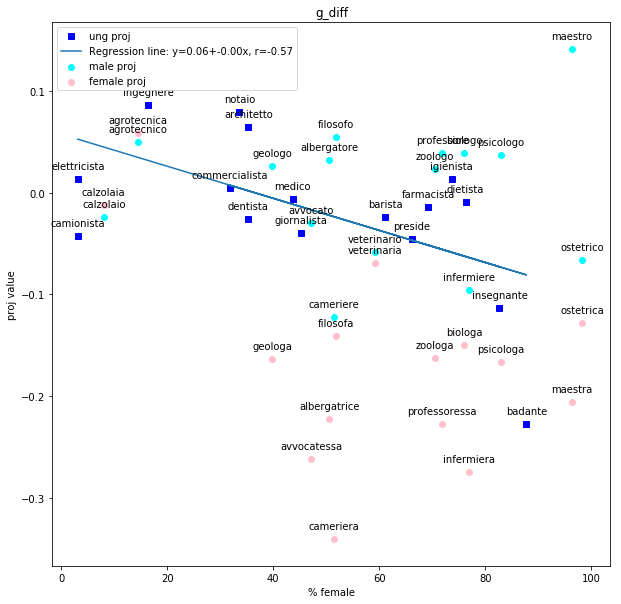

In [34]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col1, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col6, c='pink', label='female proj')
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_g_diff')

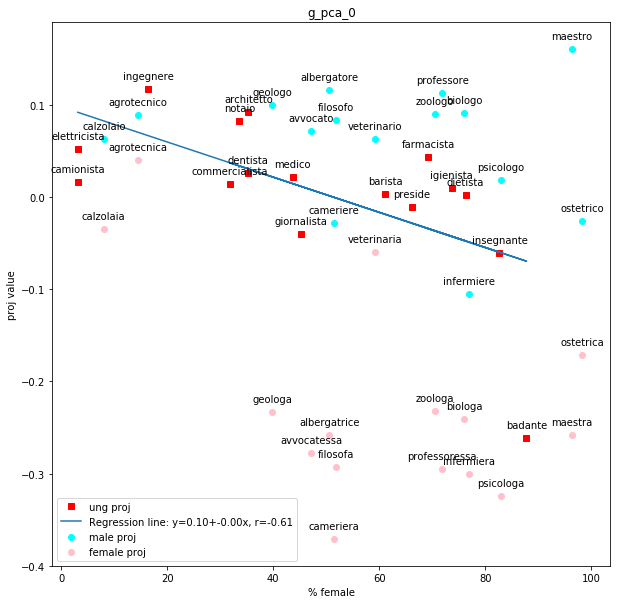

In [35]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col2, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col7, c='pink', label='female proj')
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.show()
#fig.savefig('plot/gen/ft_g_pca_0')

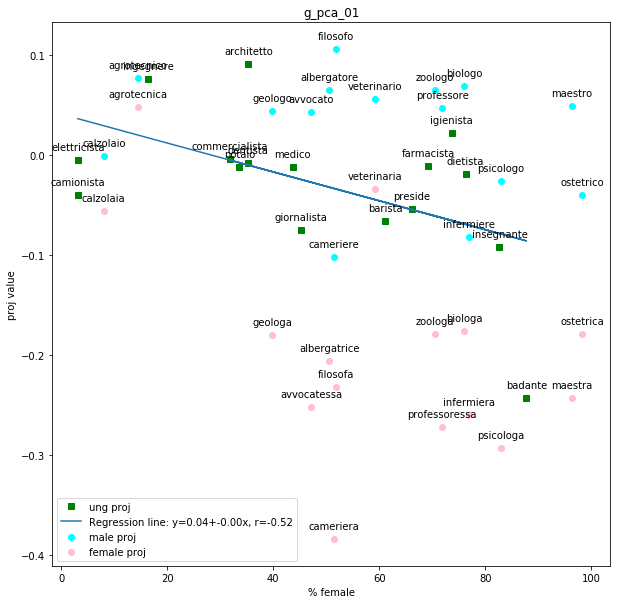

In [36]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col3, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col8, c='pink', label='female proj')
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col8[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_g_pca_01')

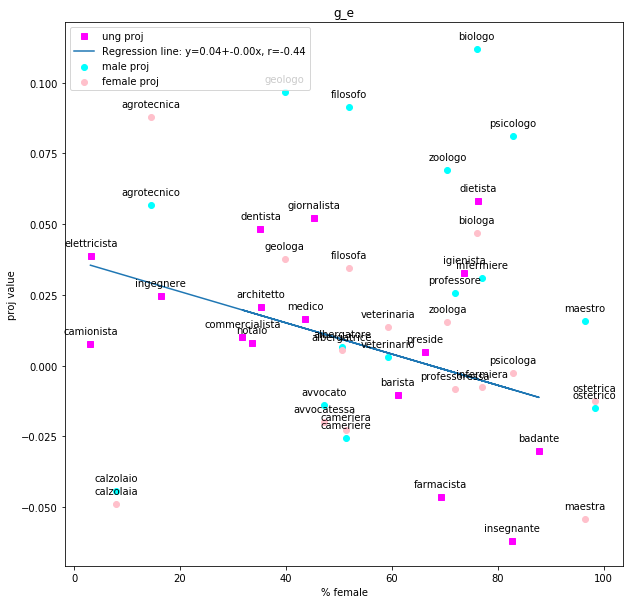

In [37]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col4, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col9, c='pink', label='female proj')
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col9[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_g_e')

##### Ungendered + mean gendered professions

In [38]:
# print mean results
mean_col0 = []
mean_col1 = []
mean_col2 = []
mean_col3 = []
mean_col4 = []
mean_col5 = []

for i in range(len(proj_ung_g_diff)):
    mean_col0.append(proj_ung_g_diff[i][0]) # profession
    mean_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    mean_col2.append(-proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    mean_col3.append(-proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    mean_col4.append(-np.real(proj_ung_g_e[i][1])) # projection on g_e
    mean_col5.append(proj_ung_g_diff[i][3]) # %female
    
for i in range(len(proj_gen_g_diff)):
    mean_col0.append(proj_gen_g_diff[i][0]) # profession
    mean_col1.append((proj_gen_g_diff[i][1]+proj_gen_g_diff[i][3])/2) # mean projection on g_diff
    mean_col2.append(-(proj_gen_g_pca_0[i][1]+proj_gen_g_pca_0[i][3])/2) # mean projection on g_pca_0
    mean_col3.append(-(proj_gen_g_pca_01[i][1]+proj_gen_g_pca_01[i][3])/2) # mean projection on g_pca_01
    mean_col4.append(-(np.real(proj_gen_g_e[i][1])+np.real(proj_gen_g_e[i][3]))/2) # mean projection on g_e
    mean_col5.append(proj_gen_g_diff[i][4]) # %female
    
mean_data = {'Profession':mean_col0, 
           'Proj g_diff':mean_col1,
           'Proj g_pca_0':mean_col2, 
           'Proj g_pca_01':mean_col3,
           'Prog g_e':mean_col4, 
           '% female':mean_col5}

mean_table = pd.DataFrame(mean_data)
mean_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% female
0,camionista,-0.042458,0.016446,-0.040143,0.007540,3.1
1,elettricista,0.013177,0.051736,-0.005166,0.038902,3.2
2,ingegnere,0.085678,0.117457,0.075780,0.024595,16.4
3,architetto,0.064599,0.092906,0.091133,0.020600,35.3
4,notaio,0.079254,0.082158,-0.012314,0.008138,33.6
5,commercialista,0.004727,0.014477,-0.003712,0.010050,31.8
6,giornalista,-0.039752,-0.040363,-0.074976,0.052038,45.3
7,insegnante,-0.113096,-0.060914,-0.091841,-0.061973,82.7
8,barista,-0.023749,0.003859,-0.065955,-0.010324,61.1
9,medico,-0.005949,0.021420,-0.011979,0.016444,43.7


In [39]:
# pearson correlation
r_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[0]
r_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[0]
r_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[0]
r_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[0]

p_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[1]
p_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[1]
p_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[1]
p_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[1]

In [40]:
pearson_data = {'g_diff':[r_mean_g_diff,p_mean_g_diff],
                'g_pca_0':[r_mean_g_pca_0,p_mean_g_pca_0],
                'g_pca_01':[r_mean_g_pca_01,p_mean_g_pca_01],
                'g_e':[r_mean_g_e,p_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.490016,-0.589281,-0.533718,-0.201817
p,0.005138,0.000487,0.001987,0.276267


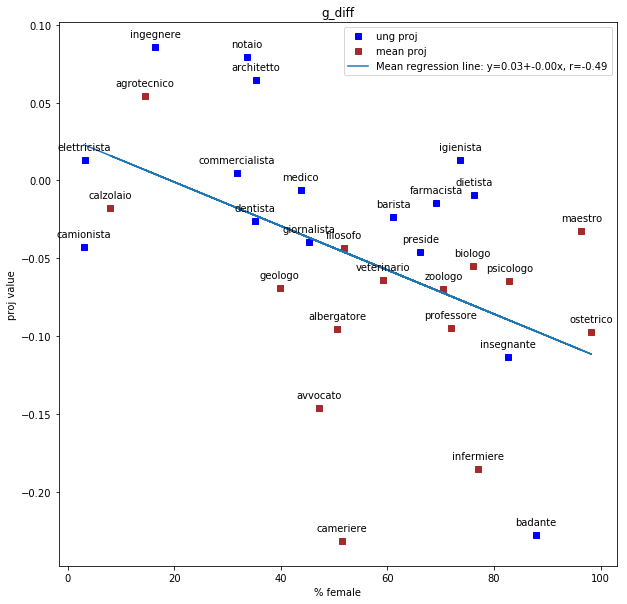

In [41]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_g_diff')

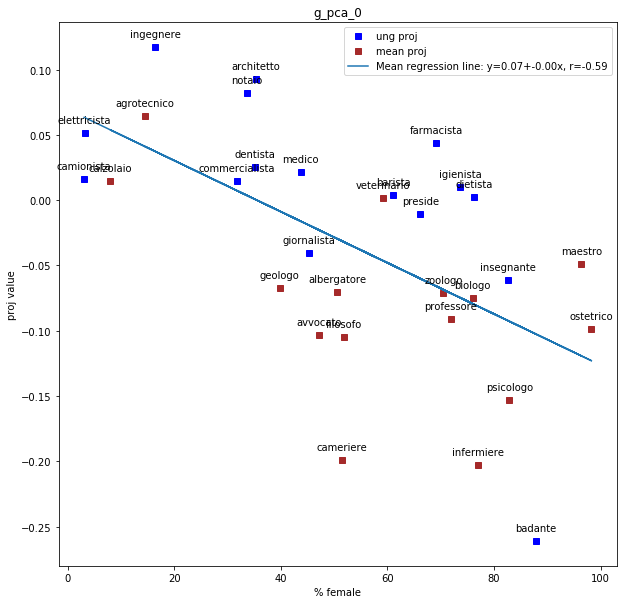

In [42]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_g_pca_0')

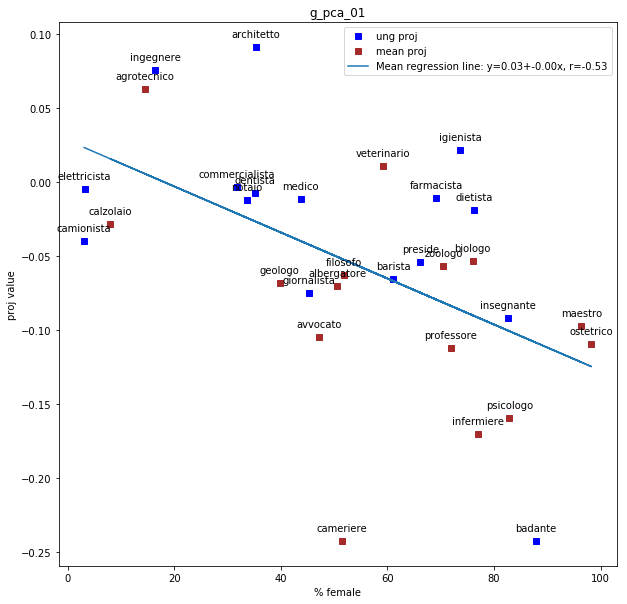

In [43]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col3)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col3[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col3[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_g_pca_01')

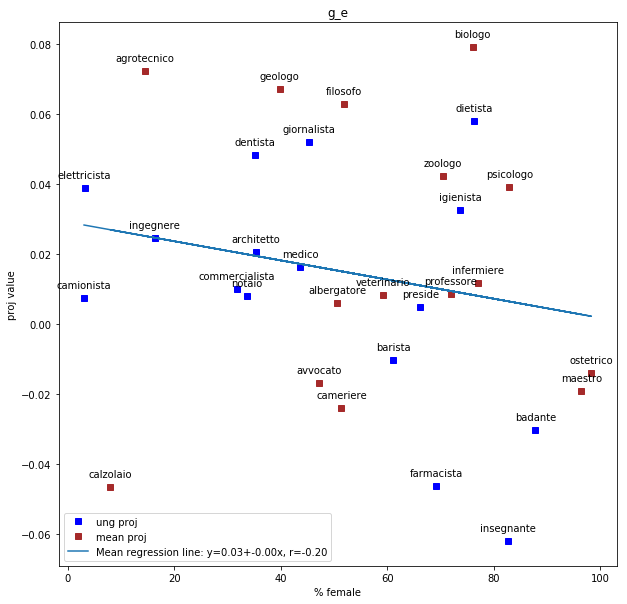

In [44]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col4)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col4[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col4[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_g_e')

#### Step 2.5: subtracting grammatical gender to the emdeddings

In [19]:
from debiaswe.debias import debias

In [20]:
debias(E_ft, [], G_word, [])

465 words of dimension 300 : sua, suo, prima, italiano, ..., credulona, calzolaia, supportivo, agrotecnica
set()
465 words of dimension 300 : sua, suo, prima, italiano, ..., credulona, calzolaia, supportivo, agrotecnica


#### Step 2.6: repeating Steps 2.1-2.4

In [21]:
# gender direction
g_diff = E_ft.diff('lui', 'lei')

In [22]:
# list of pairs to define gender
'''
gender_pairs = [['lei','lui'],
                ['donna','uomo'], 
                ['madre','padre'],
                ['moglie','marito'],
                ['sorella','fratello'],
                ['femmina','maschio']]
'''

gender_pairs = [['lui','lei'],
                ['uomo','donna'], 
                ['padre','madre'],
                ['marito','moglie'],
                ['fratello','sorella'],
                ['maschio','femmina']]

In [23]:
# PCA
pca = we.doPCA(gender_pairs, E_ft)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [24]:
print("Singular values:")
print(sv)

Singular values:
[7.2583288e-01 4.8852363e-01 3.9915085e-01 3.5123977e-01 3.3286557e-01
 2.6009700e-01 7.1481601e-08 5.7407664e-08 4.5535760e-08 4.1550784e-08]


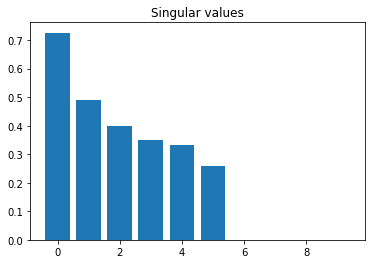

In [25]:
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()

In [56]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])
g_pca_01 = (sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1])/LA.norm((sv[0]*pc[0]+sv[1]*pc[1])/(sv[0]+sv[1]))

In [27]:
'''
S_word = [['lei','lui'],
          ['donna','uomo'],
          ['madre','padre'],
          ['moglie','marito'],
          ['sorella','fratello'],
          ['femmina','maschio']]
'''

S_word = [['lui','lei'],
          ['uomo','donna'], 
          ['padre','madre'],
          ['marito','moglie'],
          ['fratello','sorella'],
          ['maschio','femmina']]

G_word = db.read('gram_def_mf.txt', 'mf')

In [28]:
S_m_v = []
for w in S_word:
    S_m_v.append(E_ft.v(w[1]))
    
S_f_v = []
for w in S_word:
    S_f_v.append(E_ft.v(w[0]))
    
G_m_v = []
for w in G_word:
    G_m_v.append(E_ft.v(w[0]))
    
G_f_v = []
for w in G_word:
    G_f_v.append(E_ft.v(w[1]))

S_m = np.array(S_m_v).T
S_f = np.array(S_f_v).T
G_m = np.array(G_m_v).T
G_f = np.array(G_f_v).T

In [29]:
# delta semantic
Delta_S = np.dot(np.subtract(S_m, S_f), np.subtract(S_m, S_f).T)

# delta grammatical
Delta_G = np.dot(np.subtract(G_m, G_f), np.subtract(G_m, G_f).T)

# A
A = np.dot(np.linalg.inv(Delta_G), Delta_S)

In [30]:
# eigenvalues and eigenvectors
w, v = np.linalg.eig(A)

# gender direction: pick the eigenvector associated to the largest eigenvalue
g_e = v[:,np.argmax(w)] # already normalized

##### Ungendered professions

In [31]:
# read professions
prof_ung_truth = db.read('professions_ung.csv', 'truth')

In [32]:
# compute projection of each profession on g_diff
proj_ung_g_diff = db.prof_proj(E_ft, prof_ung_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_ung_g_pca_0 = db.prof_proj(E_ft, prof_ung_truth, g_pca_0, 'istat')

# compute projection of each profession on g_pca_01
proj_ung_g_pca_01 = db.prof_proj(E_ft, prof_ung_truth, g_pca_01, 'istat')

# compute projection of each profession on g_e
proj_ung_g_e = db.prof_proj(E_ft, prof_ung_truth, g_e, 'istat')

In [34]:
# print results
ung_col0 = [] # pandas columns
ung_col1 = []
ung_col2 = []
ung_col3 = []
ung_col4 = []
ung_col5 = []
ung_col6 = []

for i in range(len(proj_ung_g_diff)):
    ung_col0.append(proj_ung_g_diff[i][0]) # profession
    ung_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    ung_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    ung_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    ung_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    ung_col5.append(proj_ung_g_diff[i][2]) # %male
    ung_col6.append(proj_ung_g_diff[i][3]) # %female

    
ung_data = {'Profession':ung_col0, 
           'Proj g_diff':ung_col1,
           'Proj g_pca_0':ung_col2, 
           'Proj g_pca_01':ung_col3,
           'Prog g_e':ung_col4,
           '% male':ung_col5, 
           '% female':ung_col6}
ung_table = pd.DataFrame(ung_data)
ung_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% male,% female
0,camionista,-0.048458,-0.000451,-0.057633,-0.022193,96.9,3.1
1,elettricista,0.009945,0.042770,-0.018281,-0.114397,96.8,3.2
2,ingegnere,0.071331,0.090488,0.048954,-0.106417,83.6,16.4
3,architetto,0.053670,0.072968,0.073579,-0.098730,64.7,35.3
4,notaio,0.074839,0.067856,-0.033330,0.003811,66.4,33.6
5,commercialista,-0.006066,-0.010275,-0.023310,0.045296,68.2,31.8
6,giornalista,-0.036989,-0.041559,-0.077481,-0.024232,54.7,45.3
7,insegnante,-0.110772,-0.063286,-0.093220,-0.053280,17.3,82.7
8,barista,-0.039266,-0.035007,-0.098730,-0.014077,38.9,61.1
9,medico,-0.023249,-0.018760,-0.043919,0.023364,56.3,43.7


In [35]:
#ung_table.to_csv('truth_ung_ft_deb.csv', index=False)

In [36]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[0]
r_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[0]
r_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[0]

p_g_diff = scipy.stats.pearsonr(ung_col6, ung_col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(ung_col6, ung_col2)[1]
p_g_pca_01 = scipy.stats.pearsonr(ung_col6, ung_col3)[1]
p_g_e = scipy.stats.pearsonr(ung_col6, ung_col4)[1]

In [37]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0],
                'g_pca_01':[r_g_pca_01,p_g_pca_01],
                'g_e':[r_g_e,p_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.558589,-0.605131,-0.477666,0.491441
p,0.024510,0.013003,0.061315,0.053203


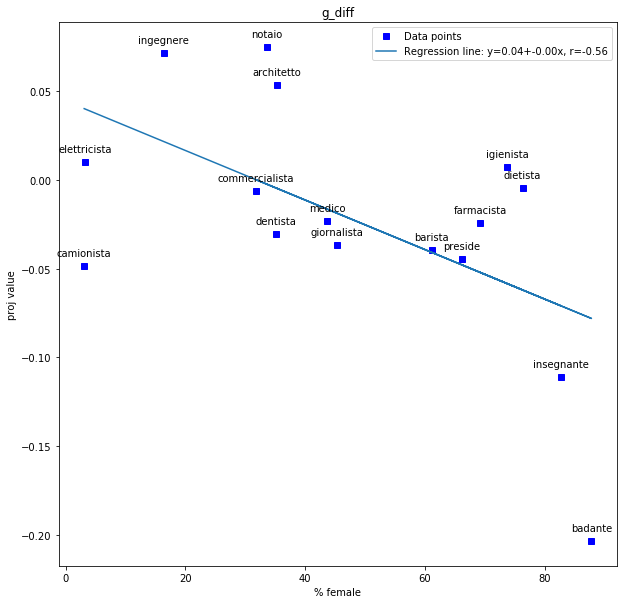

In [38]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_diff")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_deb_g_diff')

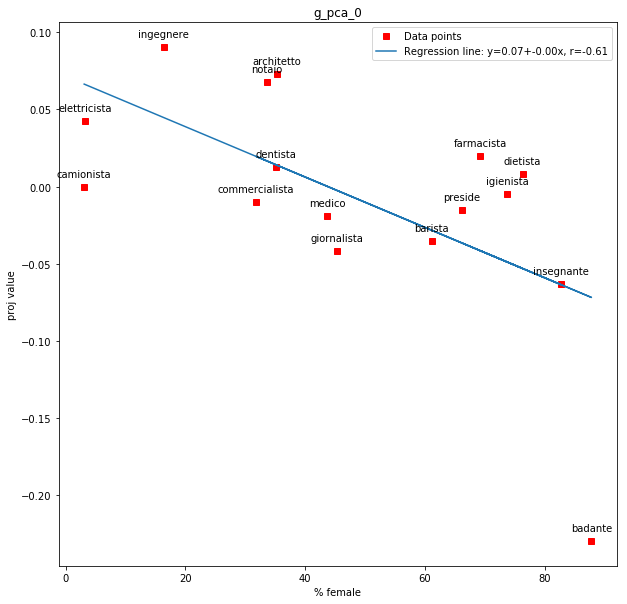

In [39]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_deb_g_pca_0')

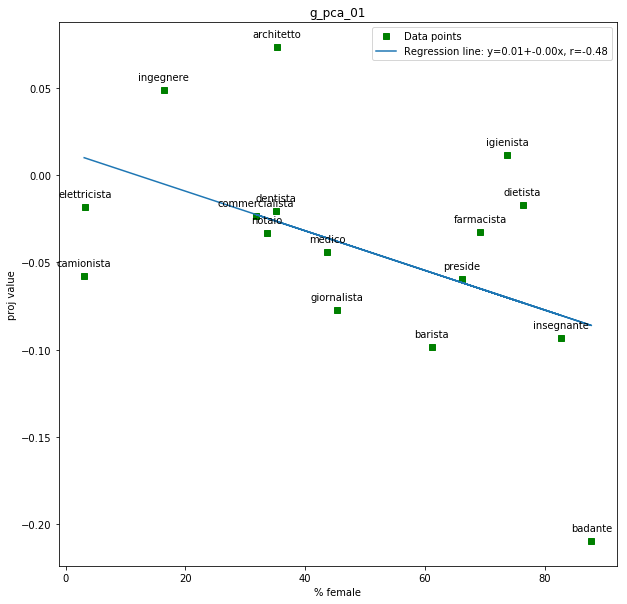

In [40]:
# correlation plot g_pca_01
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_pca_01")

ax.legend(facecolor='white')
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_deb_g_pca_01')

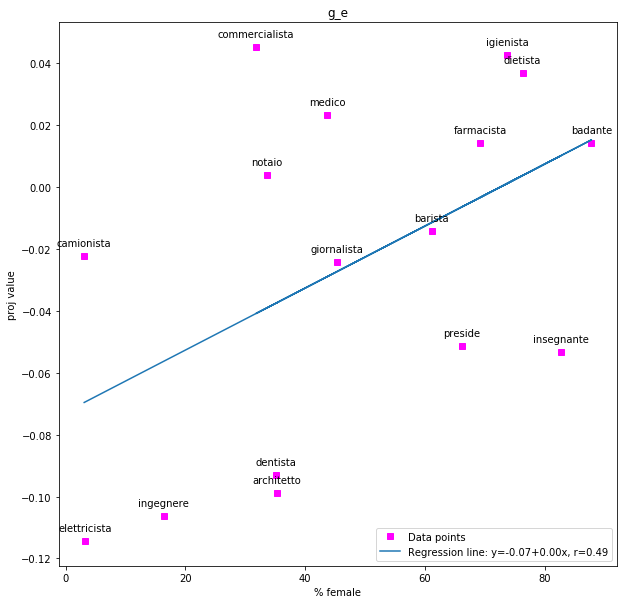

In [41]:
# correlation plot g_e
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='Data points')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.set_title("g_e")
ax.legend(facecolor='white')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_deb_g_e')

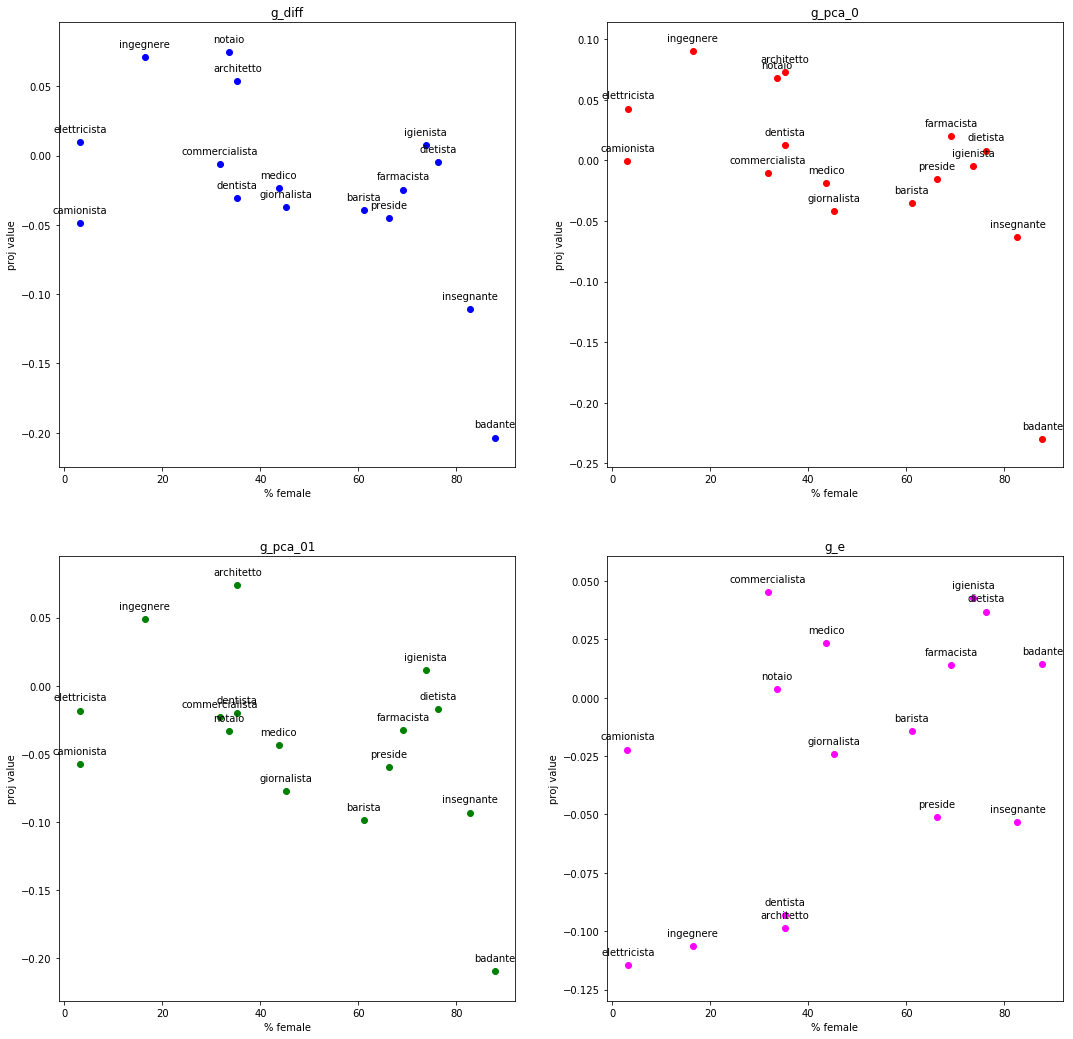

In [42]:
# scatter plots

plt.figure(figsize=(18,18))    

ax1 = plt.subplot(221)
ax1.scatter(ung_col6, ung_col1, c='blue')
ax1.set_title('g_diff')
ax1.set_xlabel('% female')
ax1.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax2 = plt.subplot(222)
ax2.scatter(ung_col6, ung_col2, c='red')
ax2.set_title('g_pca_0')
ax2.set_xlabel('% female')
ax2.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    
ax3 = plt.subplot(223)
ax3.scatter(ung_col6, ung_col3, c='green')
ax3.set_title('g_pca_01')
ax3.set_xlabel('% female')
ax3.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax4 = plt.subplot(224)
ax4.scatter(ung_col6, ung_col4, c='magenta')
ax4.set_title('g_e')
ax4.set_xlabel('% female')
ax4.set_ylabel('proj value')

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_all')

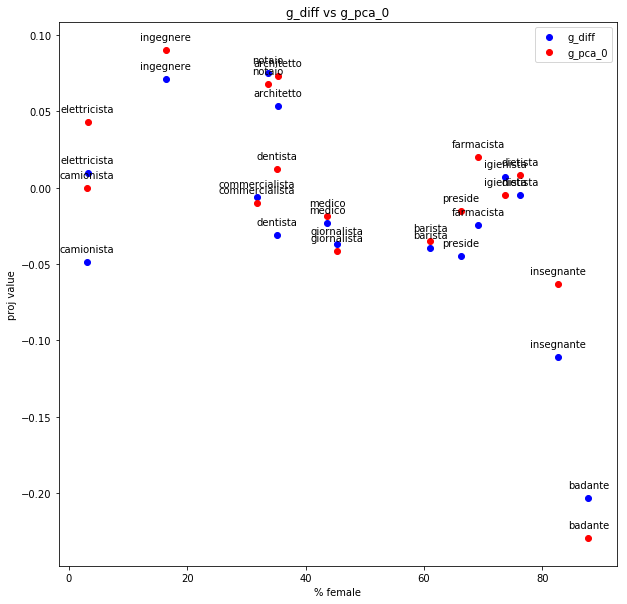

In [43]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.set_title('g_diff vs g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_g_diff_vs_g_pca_0')

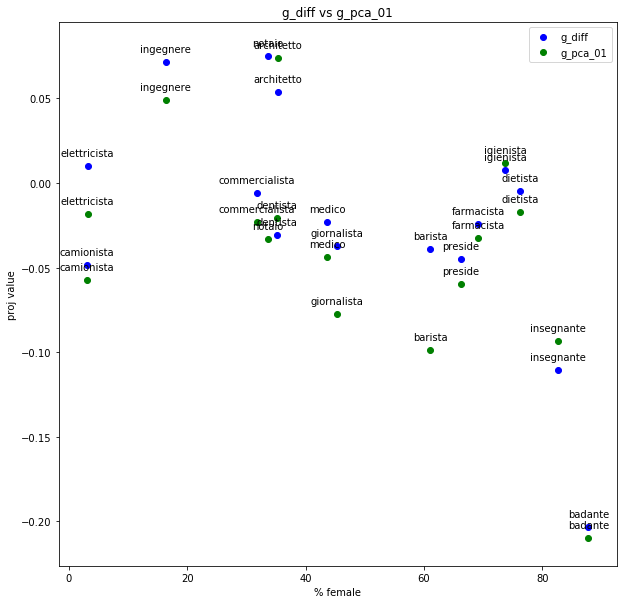

In [44]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_diff vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_g_diff_vs_g_pca_01')

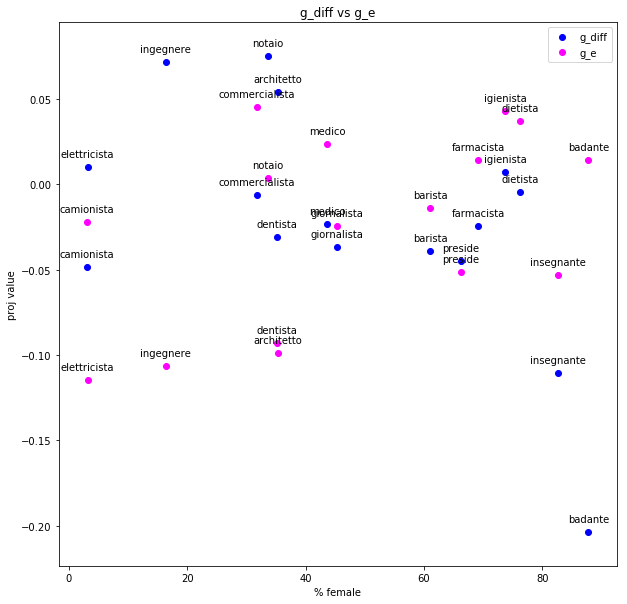

In [45]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col1, c='blue', label='g_diff')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_diff vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_g_diff_vs_g_e')

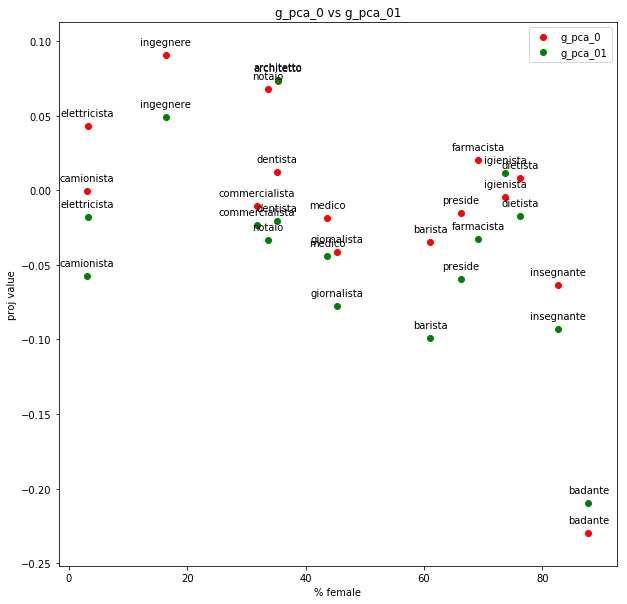

In [46]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.set_title('g_pca_0 vs g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_g_pca_0_vs_g_pca_01')

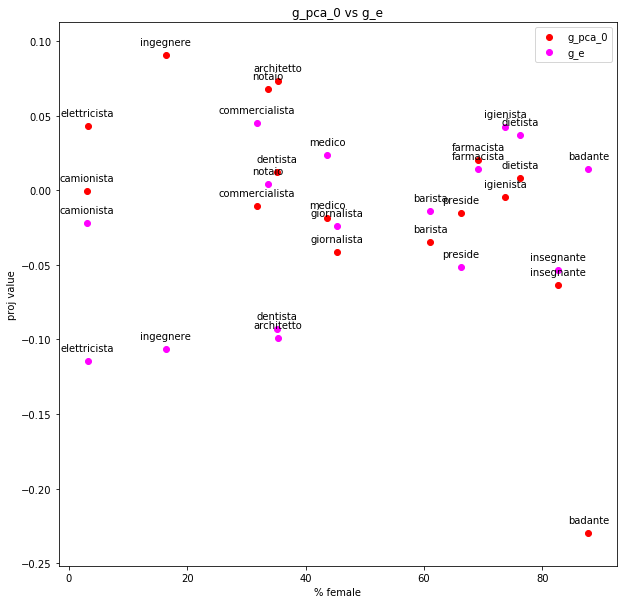

In [47]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col2, c='red', label='g_pca_0')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_0 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_g_pca_0_vs_g_e')

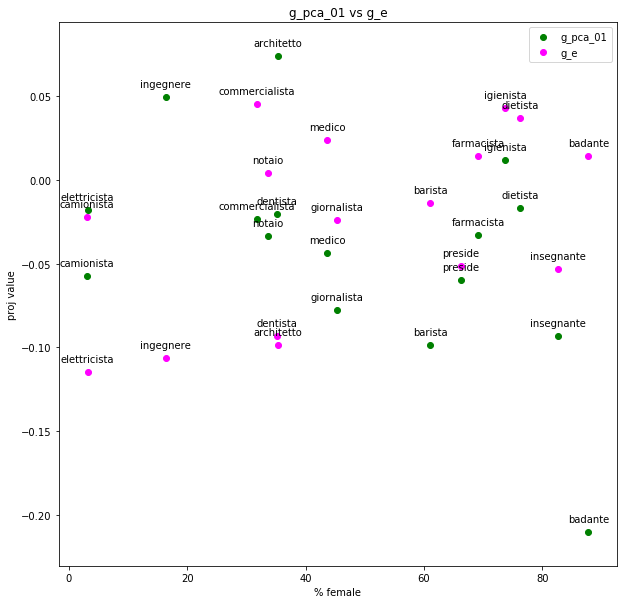

In [48]:
fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.scatter(ung_col6, ung_col3, c='green', label='g_pca_01')
ax.scatter(ung_col6, ung_col4, c='magenta', label='g_e')
ax.set_title('g_pca_01 vs g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/scatter/ft_deb_g_pca_01_vs_g_e')

##### Gendered professions

In [49]:
# read professions
prof_gen_truth = db.read('professions_gen.csv', 'truth-mf')

In [50]:
# compute projection of each profession on g_diff
proj_gen_g_diff = db.prof_proj(E_ft, prof_gen_truth, g_diff, 'istat-mf')

# compute projection of each profession on g_pca_0
proj_gen_g_pca_0 = db.prof_proj(E_ft, prof_gen_truth, g_pca_0, 'istat-mf')

# compute projection of each profession on g_pca_01
proj_gen_g_pca_01 = db.prof_proj(E_ft, prof_gen_truth, g_pca_01, 'istat-mf')

# compute projection of each profession on g_e
proj_gen_g_e = db.prof_proj(E_ft, prof_gen_truth, g_e, 'istat-mf')

In [51]:
# print results
gen_col0 = [] # pandas columns
gen_col1 = []
gen_col2 = []
gen_col3 = []
gen_col4 = []
gen_col5 = []
gen_col6 = []
gen_col7 = []
gen_col8 = []
gen_col9 = []
gen_col10 = []

for i in range(len(proj_gen_g_diff)):
    gen_col0.append(proj_gen_g_diff[i][0]) # male profession
    gen_col1.append(proj_gen_g_diff[i][1]) # male projection on g_diff
    gen_col2.append(-proj_gen_g_pca_0[i][1]) # male projection on g_pca_0
    gen_col3.append(-proj_gen_g_pca_01[i][1]) # male projection on g_pca_01
    gen_col4.append(-np.real(proj_gen_g_e[i][1])) # male projection on g_e
    gen_col5.append(proj_gen_g_diff[i][2]) # female profession
    gen_col6.append(proj_gen_g_diff[i][3]) # female projection on g_diff
    gen_col7.append(-proj_gen_g_pca_0[i][3]) # female projection on g_pca_0
    gen_col8.append(-proj_gen_g_pca_01[i][3]) # female projection on g_pca_01
    gen_col9.append(-np.real(proj_gen_g_e[i][3])) # female projection on g_e
    gen_col10.append(proj_gen_g_diff[i][4]) # %female
    
gen_data = {'Male profession':gen_col0, 
           'M-Proj g_diff':gen_col1,
           'M-Proj g_pca_0':gen_col2, 
           'M-Proj g_pca_01':gen_col3,
           'M-Prog g_e':gen_col4,
           'Female profession':gen_col5, 
           'F-Proj g_diff':gen_col6,
           'F-Proj g_pca_0':gen_col7, 
           'F-Proj g_pca_01':gen_col8,
           'F-Prog g_e':gen_col9,  
           '% female':gen_col10}

gen_table = pd.DataFrame(gen_data)
gen_table

,Male profession,M-Proj g_diff,M-Proj g_pca_0,M-Proj g_pca_01,M-Prog g_e,Female profession,F-Proj g_diff,F-Proj g_pca_0,F-Proj g_pca_01,F-Prog g_e,% female
0,calzolaio,-0.040706,-0.027721,0.033366,0.001031,calzolaia,-0.011437,0.040435,0.060964,-0.031850,8.0
1,biologo,0.021399,-0.056985,-0.038977,-0.045032,biologa,-0.119658,0.194058,0.130141,0.006616,76.0
2,avvocato,-0.039539,-0.053105,-0.024949,0.071301,avvocatessa,-0.234886,0.238846,0.213239,0.012062,47.2
3,psicologo,0.022959,0.017554,0.056054,0.006994,psicologa,-0.136192,0.288594,0.254956,0.005481,82.9
4,maestro,0.122718,-0.121437,-0.005153,-0.029945,maestra,-0.171448,0.202468,0.194650,-0.001154,96.4
5,professore,0.025638,-0.088659,-0.019518,0.057409,professoressa,-0.198786,0.256239,0.232276,0.044806,71.9
6,cameriere,-0.139312,0.071374,0.136247,0.055750,cameriera,-0.313841,0.340082,0.351231,0.059575,51.4
7,albergatore,0.026000,-0.107717,-0.049729,0.041346,albergatrice,-0.187600,0.199205,0.151992,0.042333,50.6
8,infermiere,-0.103239,0.130551,0.093158,0.088516,infermiera,-0.251674,0.271988,0.225911,0.073726,77.0
9,geologo,0.014586,-0.079258,-0.021597,0.006707,geologa,-0.134657,0.188429,0.136893,0.008045,39.8


In [52]:
#gen_table.to_csv('truth_gen_ft_deb.csv', index=False)

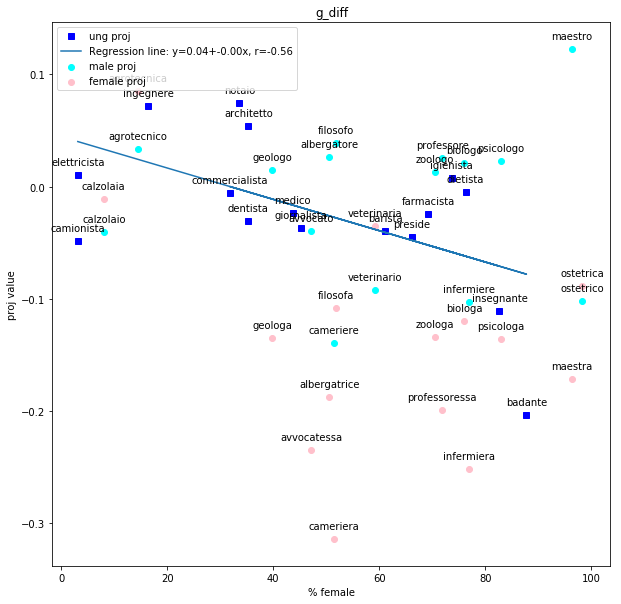

In [53]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col1, linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col1, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col6, c='pink', label='female proj')
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col6[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_deb_g_diff')

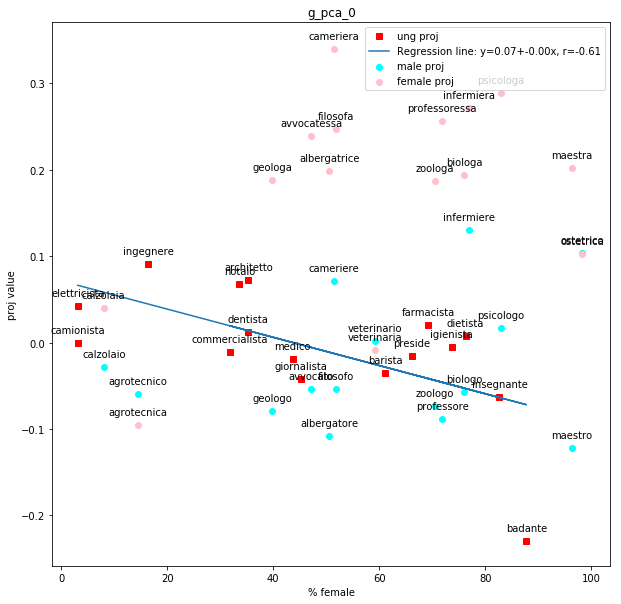

In [54]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col2)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col2, linewidth=0, marker='s', color='red', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col2, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col7, c='pink', label='female proj')
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col7[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.show()
#fig.savefig('plot/gen/ft_deb_g_pca_0')

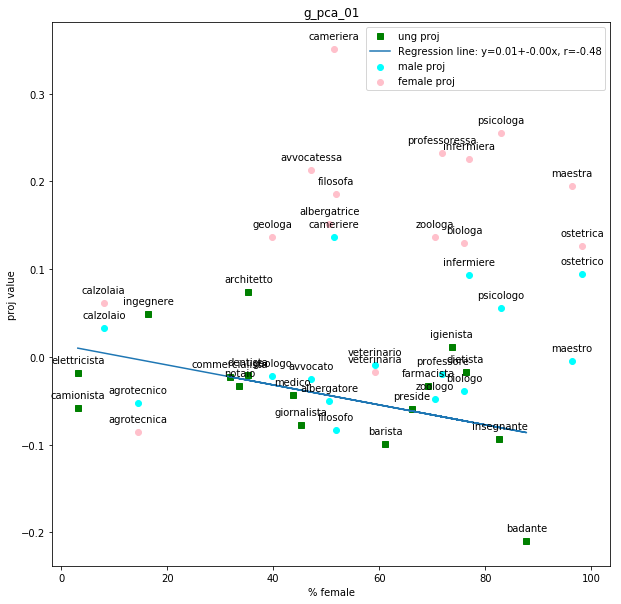

In [55]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col3)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col3, linewidth=0, marker='s', color='green', label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col3, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col8, c='pink', label='female proj')
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col8[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_deb_g_pca_01')

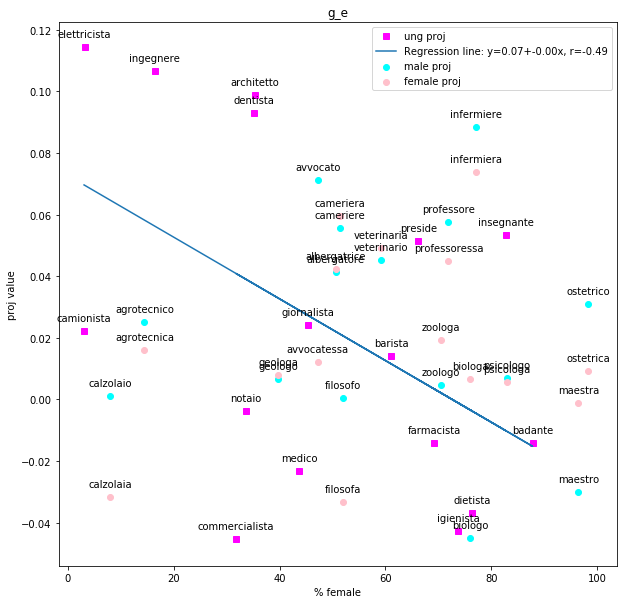

In [81]:
slope, intercept, r, p, stderr = scipy.stats.linregress(ung_col6, ung_col4)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(ung_col6, ung_col4, linewidth=0, marker='s', color='magenta',label='ung proj')
ax.plot(np.array(ung_col6), intercept + slope * np.array(ung_col6), label=line)
ax.scatter(gen_col10, gen_col4, c='cyan', label='male proj')
ax.scatter(gen_col10, gen_col9, c='pink', label='female proj')
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i,label in enumerate(gen_col0):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i,label in enumerate(gen_col5):
    plt.annotate(label, # this is the text
                 (gen_col10[i], gen_col9[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for i, label in enumerate(ung_col0):
    plt.annotate(label, # this is the text
                 (ung_col6[i], ung_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/gen/ft_deb_g_e')

##### Ungendered + mean gendered professions

In [80]:
# print mean results
mean_col0 = []
mean_col1 = []
mean_col2 = []
mean_col3 = []
mean_col4 = []
mean_col5 = []

for i in range(len(proj_ung_g_diff)):
    mean_col0.append(proj_ung_g_diff[i][0]) # profession
    mean_col1.append(proj_ung_g_diff[i][1]) # projection on g_diff
    mean_col2.append(proj_ung_g_pca_0[i][1]) # projection on g_pca_0
    mean_col3.append(proj_ung_g_pca_01[i][1]) # projection on g_pca_01
    mean_col4.append(np.real(proj_ung_g_e[i][1])) # projection on g_e
    mean_col5.append(proj_ung_g_diff[i][3]) # %female
    
for i in range(len(proj_gen_g_diff)):
    mean_col0.append(proj_gen_g_diff[i][0]) # profession
    mean_col1.append((proj_gen_g_diff[i][1]+proj_gen_g_diff[i][3])/2) # mean projection on g_diff
    mean_col2.append((proj_gen_g_pca_0[i][1]+proj_gen_g_pca_0[i][3])/2) # mean projection on g_pca_0
    mean_col3.append((proj_gen_g_pca_01[i][1]+proj_gen_g_pca_01[i][3])/2) # mean projection on g_pca_01
    mean_col4.append((np.real(proj_gen_g_e[i][1])+np.real(proj_gen_g_e[i][3]))/2) # mean projection on g_e
    mean_col5.append(proj_gen_g_diff[i][4]) # %female
    
mean_data = {'Profession':mean_col0, 
           'Proj g_diff':mean_col1,
           'Proj g_pca_0':mean_col2, 
           'Proj g_pca_01':mean_col3,
           'Prog g_e':mean_col4, 
           '% female':mean_col5}

mean_table = pd.DataFrame(mean_data)
mean_table

,Profession,Proj g_diff,Proj g_pca_0,Proj g_pca_01,Prog g_e,% female
0,camionista,-0.048458,-0.000451,-0.057633,-0.022193,3.1
1,elettricista,0.009945,0.042770,-0.018281,-0.114397,3.2
2,ingegnere,0.071331,0.090488,0.048954,-0.106417,16.4
3,architetto,0.053670,0.072968,0.073579,-0.098730,35.3
4,notaio,0.074839,0.067856,-0.033330,0.003811,33.6
5,commercialista,-0.006066,-0.010275,-0.023310,0.045296,31.8
6,giornalista,-0.036989,-0.041559,-0.077481,-0.024232,45.3
7,insegnante,-0.110772,-0.063286,-0.093220,-0.053280,82.7
8,barista,-0.039266,-0.035007,-0.098730,-0.014077,61.1
9,medico,-0.023249,-0.018760,-0.043919,0.023364,43.7


In [81]:
# pearson correlation
r_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[0]
r_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[0]
r_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[0]
r_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[0]

p_mean_g_diff = scipy.stats.pearsonr(mean_col5, mean_col1)[1]
p_mean_g_pca_0 = scipy.stats.pearsonr(mean_col5, mean_col2)[1]
p_mean_g_pca_01 = scipy.stats.pearsonr(mean_col5, mean_col3)[1]
p_mean_g_e = scipy.stats.pearsonr(mean_col5, mean_col4)[1]

In [82]:
pearson_data = {'g_diff':[r_mean_g_diff,p_mean_g_diff],
                'g_pca_0':[r_mean_g_pca_0,p_mean_g_pca_0],
                'g_pca_01':[r_mean_g_pca_01,p_mean_g_pca_01],
                'g_e':[r_mean_g_e,p_mean_g_e]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0,g_pca_01,g_e
r,-0.468778,-0.577998,-0.490386,0.298266
p,0.007813,0.000661,0.005100,0.103150


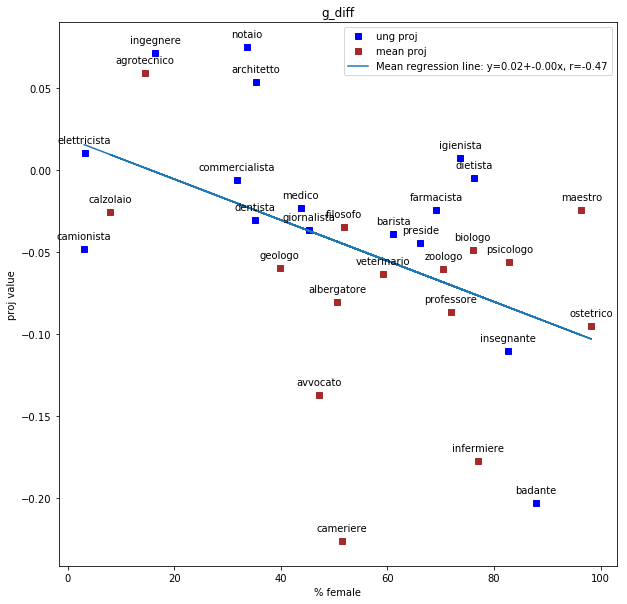

In [78]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col1)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col1[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col1[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_diff')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_deb_g_diff')

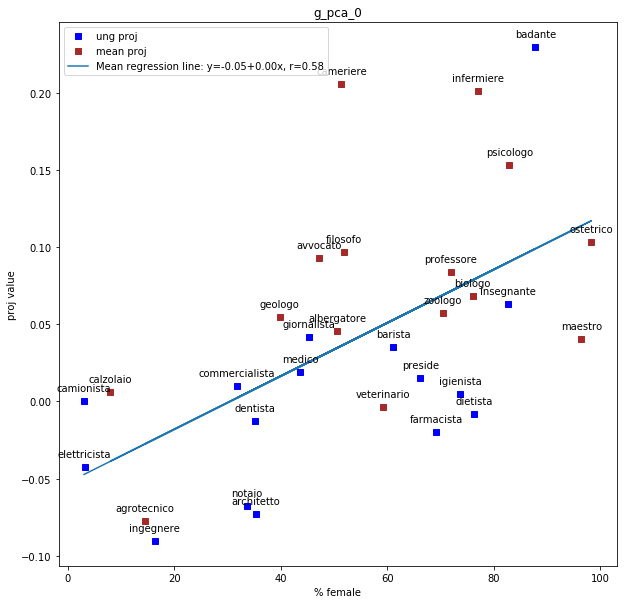

In [79]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col2)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col2[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col2[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_0')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_deb_g_pca_0')

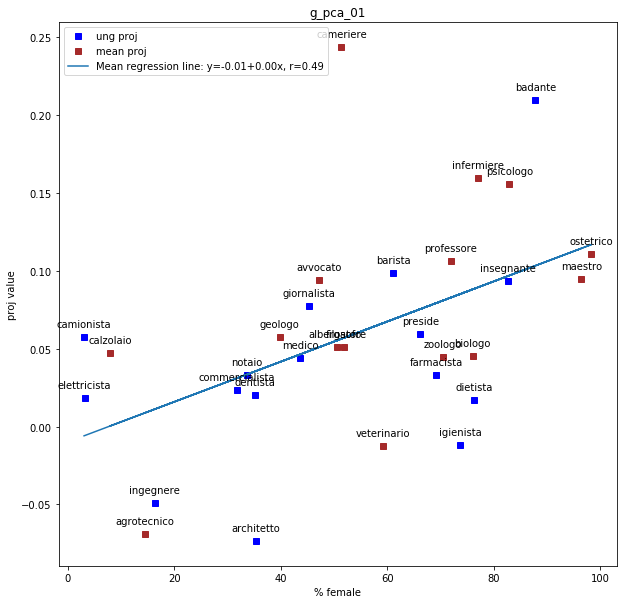

In [87]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col3)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col3[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col3[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_pca_01')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col3[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_deb_g_pca_01')

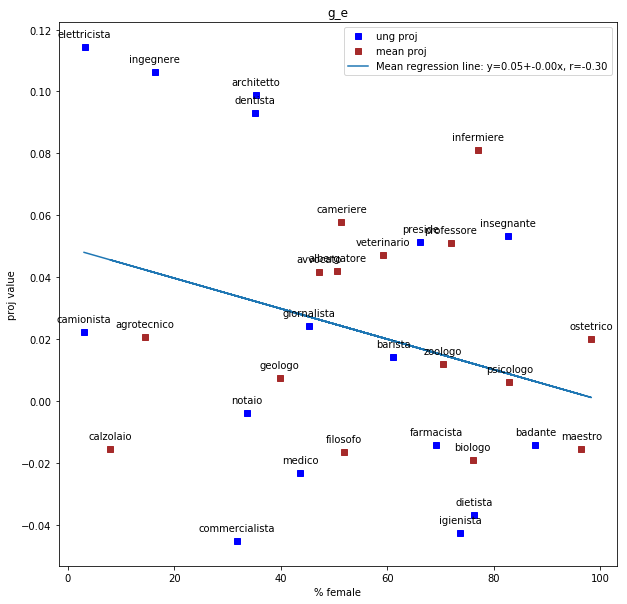

In [88]:
# scatter plots
slope, intercept, r, p, stderr = scipy.stats.linregress(mean_col5, mean_col4)
line = f'Mean regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.plot(mean_col5[:16], mean_col4[:16], linewidth=0, marker='s', color='blue', label='ung proj')
ax.plot(mean_col5[16:], mean_col4[16:], linewidth=0, marker='s', color='brown', label='mean proj')
ax.plot(np.array(mean_col5), intercept + slope * np.array(mean_col5), label=line)
ax.set_title('g_e')
ax.set_xlabel('% female')
ax.set_ylabel('proj value')
ax.legend()

for i, label in enumerate(mean_col0):
    plt.annotate(label, # this is the text
                 (mean_col5[i], mean_col4[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
#fig.savefig('plot/mean/ft_deb_g_e')